In [1]:
import math
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import random
import warnings

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
florida = pd.read_excel('./florida_2017.xls')
headers = ['city', 'population', 'violent_crime', 'murder', 'rape', 'robbery',
       'assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson']
florida.columns = headers
florida.set_index('city', inplace=True)

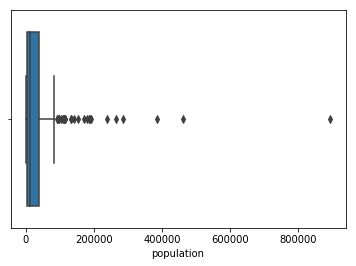

In [3]:
sns.boxplot(florida.population)

In [5]:
crime_cols = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'property_crime', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']
# so we will want to remove some outliers
florida = florida[florida.population<florida.population.quantile(0.9)]
# add a log odds variable (do not include property crimes though)
cols = ['violent_crime', 'murder', 'rape', 'robbery', 
        'assault', 'burglary', 'larceny_theft', 
        'motor_vehicle_theft', 'arson']
florida["log_odds"] = np.log1p(florida.population / florida[cols].sum(axis=1))

In [6]:
# log population
florida["population_log"] = np.log(florida.population)

# log1p first adds 1 to x then logs the result
florida["property_crime_log"] = np.log1p(florida.property_crime)

# create a population_medium indicator variable
# these are going to be relative to the population in each state
# the medium group is the interquartile range on population (between 1st and 3rd quantiles)
florida["population_medium"] = (florida.population.between(3620.0, 24929.5)).astype("int")

# create n population groups
florida["population_group"] = pd.cut(florida.population, 5, labels=list(range(1,6)))

# create robbery dummy var
florida["has_robbery"] = np.where(florida.robbery>0,1,0)
florida["has_property_crime"] = np.where(florida.property_crime>0,1,0)

# because box-cox transforms require x>0, when property_crime is 0 we add 1, else we leave it alone
florida["property_crime_2"] = florida["property_crime"].apply(lambda x: x+1 if x == 0 else x)

# burglary_cube_root
florida["burglary_cube_root"] = florida.burglary**(1/3)

# assault_log
florida["assault_log"] = np.log1p(florida.assault)

# larceny_theft_cube_root
florida["larceny_theft_cube_root"] = florida.larceny_theft ** (1/3)

# robbery_log
florida["robbery_log"] = np.log1p(florida.robbery)

# motor_vehicle_theft_log
florida["motor_vehicle_theft_log"] = np.log1p(florida.motor_vehicle_theft)

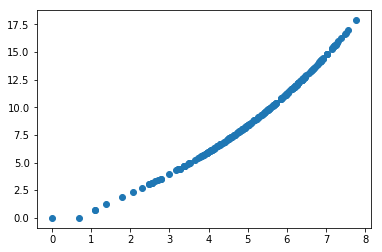

In [9]:
bc = boxcox(florida["property_crime_2"])
florida['property_crime_bc'] = bc[0]
bc_lambda = bc[1]

plt.scatter(florida["property_crime_log"], bc[0])
plt.show()

In [10]:
florida.skew()

population                  1.197
violent_crime               2.576
murder                      4.237
rape                        2.423
robbery                     4.245
assault                     2.559
property_crime              1.695
burglary                    2.023
larceny_theft               1.708
motor_vehicle_theft         2.327
arson                       2.778
log_odds                    0.550
population_log             -0.497
property_crime_log         -0.679
population_medium          -0.221
population_group            1.297
has_robbery                -1.342
has_property_crime        -15.133
property_crime_2            1.695
burglary_cube_root          0.225
assault_log                -0.146
larceny_theft_cube_root     0.282
robbery_log                 0.435
motor_vehicle_theft_log    -0.131
property_crime_bc          -0.058
dtype: float64

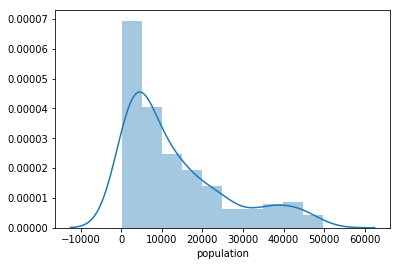

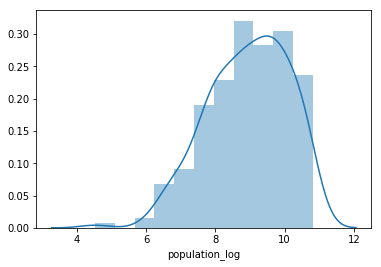

In [13]:
sns.distplot(florida.population)
plt.show()
sns.distplot(florida.population_log)
plt.show()

*Cube root of population looks to be the best to use in place of population.*

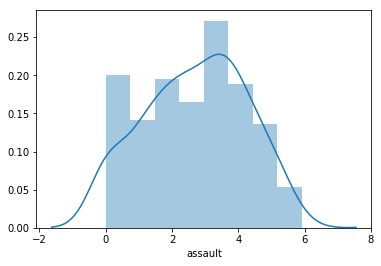

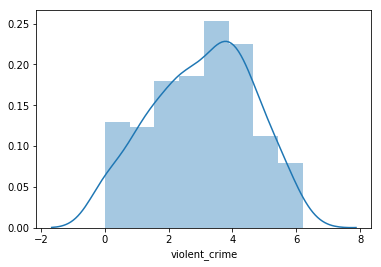

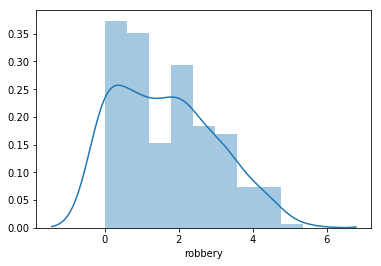

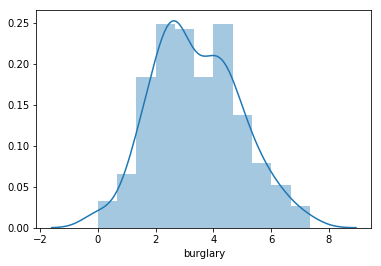

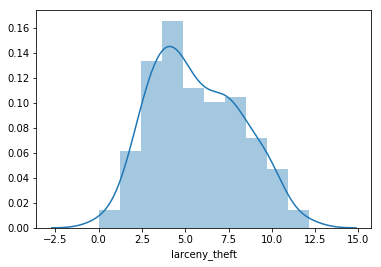

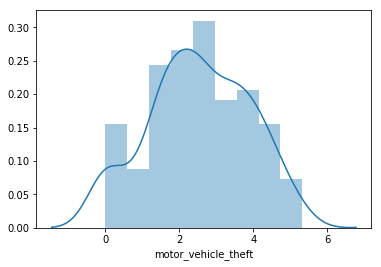

In [16]:
# split into population groups
florida["population_low"] = (florida.population < 3620.0).astype("int")
florida["population_medium"] = (florida.population.between(3620.0, 24929.5)).astype("int")
florida["population_high"] = (florida.population >= 24929.5).astype("int")

sns.distplot(np.log1p(florida.assault))
florida["assault_log"] = np.log1p(florida.assault)
plt.show()
sns.distplot(np.log1p(florida.violent_crime))
florida["violent_crime_log"] = np.log1p(florida.violent_crime)
plt.show()
sns.distplot(np.log1p(florida.robbery))
florida["robbery_log"] = np.log1p(florida.robbery) 
plt.show()
sns.distplot(florida.burglary**(1/3))
florida["burglary_cube_root"] = florida.burglary**(1/3)
plt.show()
sns.distplot(florida.larceny_theft**(1/3))
florida["larceny_theft_cube_root"] = florida.larceny_theft**(1/3)
plt.show()
sns.distplot(np.log1p(florida.motor_vehicle_theft))
florida["motor_vehicle_theft_log"] = np.log1p(florida.motor_vehicle_theft)
plt.show()

florida["murder_log"] = np.log1p(florida.murder)

# Split

In [17]:
florida_train = florida.sample(frac=0.7, random_state=41)
florida_test_cities = list(set(florida.index).difference(set(florida_train.index)))
florida_test = florida.loc[florida_test_cities,:]
print("Train shape: {}".format(florida_train.shape))
print("Test shape: {}".format(florida_test.shape))

Train shape: (160, 29)
Test shape: (69, 29)


# Build

## Model 1

In [60]:
model_vars = ['population_log', 'has_robbery', 
              'population_medium',
              "robbery_log", "burglary_cube_root",
              "larceny_theft_cube_root", "motor_vehicle_theft_log"]

X = florida_train[model_vars]
y = florida_train["property_crime_bc"]

model = LinearRegression()
model.fit(X, y)

resids_train = florida_train["property_crime"] - inv_boxcox(model.predict(florida_train[model_vars]), bc_lambda)
resids_test = florida_test["property_crime"] - inv_boxcox(model.predict(florida_test[model_vars]), bc_lambda)

print("TRAIN\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids_train.mean(), resids_train.std()))
print("Average Error: {}".format(np.abs(resids_train).sum()/resids_train.shape[0]))

print("\nTEST\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids_test.mean(), resids_test.std()))
print("Average Error: {}".format(np.abs(resids_test).sum()/resids_test.shape[0]))

TRAIN
********************
Mean Residual: -4.277620405106282
RMSE: 30.665012907136024
Average Error: 18.313634134543396

TEST
********************
Mean Residual: -9.228152044486766
RMSE: 66.1640680664089
Average Error: 23.381290523467385


## Model 2

For this one, we are going to use the same features as in Model 1, but condition on the population group, so:
  1. Model 2: Population Groups 1 and 2
  2. Model 3: Population Group 3
  3. Model 4: Population Groups 4 and 5

In [39]:
group1_train = florida_train[florida_train.population_group.isin([1,2])]
group3_train = florida_train[florida_train.population_group==3]
#group4_train = florida_train[florida_train.population_group==4]
group5_train = florida_train[florida_train.population_group.isin([4,5])]

group1_test = florida_test[florida_test.population_group.isin([1,2])]
group3_test = florida_test[florida_test.population_group==3]
#group4_test = florida_test[florida_test.population_group==4]
group5_test = florida_test[florida_test.population_group.isin([4,5])]

*We are then going to concatenate all of the predictions/residuals from these 3 models.*

### Population Groups 1 and 2

In [30]:
# train on population groups 1&2
regr1 = linear_model.LinearRegression()
regr1.fit(group1_train[model_vars], group1_train["property_crime_bc"])

# Save predicted values.
Y_pred1_train = inv_boxcox(regr1.predict(group1_train[model_vars]), bc_lambda)
Y_pred1_test = inv_boxcox(regr1.predict(group1_test[model_vars]), bc_lambda)
# residuals
resids1_train = group1_train["property_crime"] - Y_pred1_train
resids1_test = group1_test["property_crime"] - Y_pred1_test
print("TRAIN\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids1_train.mean(), resids1_train.std()))
print("Average Error: {}".format(np.abs(resids1_train).sum()/resids1_train.shape[0]))

print("\nTEST\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids1_test.mean(), resids1_test.std()))
print("Average Error: {}".format(np.abs(resids1_test).sum()/resids1_test.shape[0]))

TRAIN
********************
Mean Residual: -2.827585785604248
RMSE: 23.899075039453013
Average Error: 11.631028936982064

TEST
********************
Mean Residual: -5.978817408585413
RMSE: 22.674914863324318
Average Error: 14.055130324399572


### Population Group 3

In [32]:
# train on population groups 1&2
regr3 = linear_model.LinearRegression()
regr3.fit(group3_train[model_vars], group3_train["property_crime_bc"])

# Save predicted values.
Y_pred3_train = inv_boxcox(regr3.predict(group3_train[model_vars]), bc_lambda)
Y_pred3_test = inv_boxcox(regr3.predict(group3_test[model_vars]), bc_lambda)
# residuals
resids3_train = group3_train["property_crime"] - Y_pred3_train
resids3_test = group3_test["property_crime"] - Y_pred3_test
print("TRAIN\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids3_train.mean(), resids3_train.std()))
print("Average Error: {}".format(np.abs(resids3_train).sum()/resids3_train.shape[0]))

print("\nTEST\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids3_test.mean(), resids3_test.std()))
print("Average Error: {}".format(np.abs(resids3_test).sum()/resids3_test.shape[0]))

TRAIN
********************
Mean Residual: -0.1572841574825391
RMSE: 7.041061095363018
Average Error: 5.358806685158335

TEST
********************
Mean Residual: 8.182715370749548
RMSE: 4.606213785146752
Average Error: 8.182715370749548


### Population Group 4 and 5

In [40]:
# train on population groups 1&2
regr5 = linear_model.LinearRegression()
regr5.fit(group5_train[model_vars], group5_train["property_crime_bc"])

# Save predicted values.
Y_pred5_train = inv_boxcox(regr5.predict(group5_train[model_vars]), bc_lambda)
Y_pred5_test = inv_boxcox(regr5.predict(group5_test[model_vars]), bc_lambda)
# residuals
resids5_train = group5_train["property_crime"] - Y_pred5_train
resids5_test = group5_test["property_crime"] - Y_pred5_test
print("TRAIN\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids5_train.mean(), resids5_train.std()))
print("Average Error: {}".format(np.abs(resids5_train).sum()/resids5_train.shape[0]))

print("\nTEST\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids5_test.mean(), resids5_test.std()))
print("Average Error: {}".format(np.abs(resids5_test).sum()/resids5_test.shape[0]))

TRAIN
********************
Mean Residual: -0.12728157906140494
RMSE: 13.542810350695623
Average Error: 10.30282666939897

TEST
********************
Mean Residual: -30.065564804517447
RMSE: 59.868276878144904
Average Error: 48.31390558524231


In [45]:
print("({}, {})".format(group5_train.shape[0], group5_test.shape[0]))

(25, 6)


*Sampling for this group is really imbalanced...*

In [58]:
resids_all_train = np.concatenate((resids1_train.values, resids3_train.values, resids5_train.values))
resids_all_test = np.concatenate((resids1_test.values, resids3_test.values, resids5_test.values))
print("TRAIN\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids_all_train.mean(), resids_all_train.std()))
print("Average Error: {}".format(np.abs(resids_all_train).sum()/resids_all_train.shape[0]))

print("\nTEST\n********************")
print("Mean Residual: {}\nRMSE: {}".format(resids_all_test.mean(), resids_all_test.std()))
print("Average Error: {}".format(np.abs(resids_all_test).sum()/resids_all_test.shape[0]))

TRAIN
********************
Mean Residual: -2.0885649349924753
RMSE: 21.09629927728845
Average Error: 10.67867094026814

TEST
********************
Mean Residual: -7.252358760154289
RMSE: 27.446078792349326
Average Error: 16.693724407739516


# Conclusion

I built a rather simple model, to predict the Box-Cox transform of property crime (for all populations), and a second model (set) that uses the structure of the first model, but conditioned on the population group. For the second model (set), I concatenated all the residuals from the 3 individual models. 

  1. **Model 1**
    
    **TRAIN**  
      Mean Residual: -4.27  
      RMSE: 30.66  
      Average Error: 18.31  
  
    **TEST**    
      Mean Residual: -9.23  
      RMSE: 66.16  
      Average Error: 23.38  
      
  2. **Model 2**
  
    **TRAIN**  
        Mean Residual: -2.09  
        RMSE: 21.1  
        Average Error: 10.68  
      
    **TEST**  
      Mean Residual: -7.2  
      RMSE: 27.45  
      Average Error: 16.69  

So "sending" a city to a model first based on its' population makes a significant difference in the original model's performance, and we can look further at the residuals made in each population group and see that our model struggles the most with population group 4. However, we see that we split our data such that 25 such cities ended up in the train set while only 6 ended up in the test set. Such an imbalance should be corrected first. 